# Bert Study 버트가 뭐지?

이 노트북 내용은 인라이플 버트이해하기 발표자료, [BERT 톺아보기 블로그](http://docs.likejazz.com/bert/), [텐서플로와 머신러닝으로 시작하는 자연어 처리 (전창욱, 최태균, 조중현)](https://book.naver.com/bookdb/book_detail.nhn?bid=14488487)를 참고 했음을 밝힙니다.

BERT(Bidirectional Encoder Representations from Transformers)는 2018년 10월에 논문이 공개됐고, 11월에 오픈소스로 코드가 공개된 구글의 새로운 Language Representation Model입니다. 

<img src="https://user-images.githubusercontent.com/31824102/36531999-78eda612-17b7-11e8-9793-ef8dcd78dd9b.PNG"></img>

BERT는 Transformer 기반입니다. 인코더-디코더 모델이며 복잡합니다. BERT는 인코더만 사용합니다. 

## Positional Encoding (Positional Embedding)

Transformer는입력으로 토큰의 상대적 또는 절대적 위치에 대한 정보를 주입해야 합니다. Positional Encoding이라고 합니다. 사인, 코사인 함수를 이용하여 토큰의 상대적 위치와 관련한 정보를 학습할 수 있게 됩니다.

\begin{align}
PE(pos,2i) &= sin( pos/10000^{2i/dmodel}) \\
PE(pos,2i+1) &= cos( pos/10000^{2i/dmodel} )
\end{align}

BERT는 Transformer와 달리 Positional Encoding을 사용하지 않고 Position Embedding을 사용합니다. 입력 데이터는 두 문장 합쳐 약 512단어 이하로 넣고 3가지 형식으로 입력하여 임베딩합니다.

*   토큰 임베딩: 입력 단어가 단어장(Vocab)에 몇 번째 단어인지 나타냄
*   세그먼트 임베딩: 두 문장 중 앞 문장인지 뒷 문장인지 구분함
*   포지션 임베딩: 문장 내 단어의 순번을 나타냄

특수 기호 토큰들
*  0 PAD: 공백
*  1 CLS: 첫 토큰으로 항상 CLS를 넣음
*  2 UNK: 단어장에 없는 단어
*  3 SEP: 문장들을 구분해 주는 구분자
*  4 MASK: 마스크 처리

3개의 임배딩을 합산한 결과를 취합니다.

```
e = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
```

```pos```는 각 토큰의 위치 정보이며 range(0, max_len)이며 ```seg```는 토큰 타입입니다. 이제 이 값에 대한 각각의 임베딩을 얻어 합산하고 여기에 LayerNorm & Dropout 한 최종 결과를 인코더 블럭에 입력합니다.

## Encoder block

<img src="https://cdn-images-1.medium.com/max/1600/1*EblTBhM-9mOqYWMARk6ajQ.png" />

인코더 블록에서는 임베딩 결과를 가지고 셀프 어텐션과 피드 포워드 작업을 수행한다. 이 블록은 모델마다 개수가 다른데 Bert의 base 모델은 12개를 사용한다. 즉, 입력 시퀀스를 12번 반복한다는 의미이다. 

### Multi-Head Attention

인코더에서 제일 중요하다. Multi-Head Attention은 여러 해드를 가진 어텐션을 의미한다. 우선 어텐션의 개념을 배워야 한다. 

```
Attention is all you need?
어텐션은 딥러닝 모델에서 특정 벡터에 주목하도록 하여 모델의 성능을 높이는 기법이다.  
```

서로 다른 가중치 행렬(헤드)를 $h$(헤드 개수)만큼 어텐션 계산을 한 다음 서로 연결하여 결과를 만든다. Bert base모델에서는 12개 헤드를 사용한다. 768개 토큰을 12등분하여 64개 토큰을 12개 헤드에 각각 계산하고 Scaled-Dot Product를 사용하여 768로 다시 합친다.  

### Self Attention

셀프 어텐션이란 문장에서 각 단어끼리 얼마나 관계가 있는지를 계산해서 반영하는 방법이다. 셀프 어텐션을 사용하여 문장 안에 단어들 간의 관계를 측정한다. '나 자전거 타다' 란 문장이 있으면 '나'라는 단어는 '나', '자전거', '타다' 같은 다른 단어와 관계를 각각 점수로 표현 할 수 있다. 이를 어텐션 스코어라고 한다.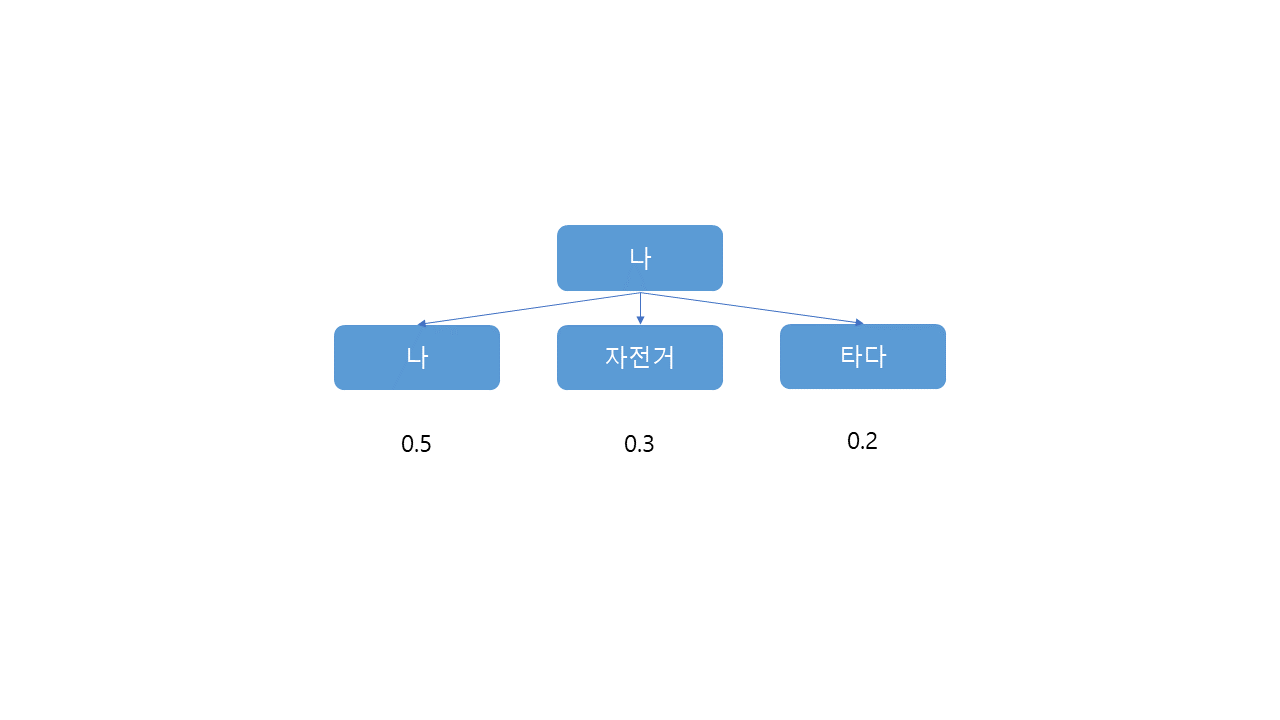

문장은 단어 벡터로 이루어 진다. 각 단어 간의 관계를 나타내는 어텐션 스코어를 구해야 한다. 벡터에 대한 맨하튼 거리와 같은 유사도 공식을 활용하는 방법과 Dense 층을 거쳐 나온 값을 활용하는 방법이 있다. 트랜스포머 모델에서는 단어 벡터끼리 내적 연산을 함으로써 어텐션 스코어를 구한다.
$$score = v1 \cdot v2$$

특정 단어 ('나' 같은)에 대한 다른 단어들과의 어텐션 스코어를 구한 후, 어텐션 스코어를 모아서 하나의 어텐션 맵을 만든다. <br>
[50, 30, 20]. <br>
그리고 이 어텐션 맵에 소프트맥스 함수를 적용하여 확률로 나타낸다. <br>
[50, 30, 20] -> $softmax$ -> [0.5, 0.3, 0.2]<br>
이 확률 값과 기존 단어 벡터를 가중합한다. 각 확률값과 각 단어 벡터를 곱한 후 벡터를 더하는 연산이다.
$$ context\space vector_i = \sum_{j} softmax(score(v_i))_i \times v_j $$ 
이런 방식으로 '나', '자전거', '타다' 같은 모든 단어에 적용하면 셀프 어텐션은 끝난다

### Multi-Head Attention

다시 멀티 헤드 어텐션에 관해 작성한다. 종 3파트로 구성하여 설명한다.

1. 스케일 내적 어텐션
    * 내적 어텐션의 입력은 총 세가지이다. Query, Key, Value이다. Query는 찾고자 하는 단어이다. Key는 사전에 등록된 단어이다. 그 Key 단어에 해당하는 의미는 Value이다. Query를 Key와 내적하여 어텐션 스코어를 구한다. 어텐션 스코어에 소프트맥스를 적용한 후 Value에 각각 곱하여 더하면 Query에 대한 컨텍스트 벡터가 생성된다. 추가로 Query와 Value를 이용해 내적을 한 값이 만약 벡터의 차원이 커지면 학습이 잘 안 될 수 있기 때문에 벡터의 크게에 반비례하도록 크기를 조정한다. 
    $$ Attention(Q, K, V) = softmax( \dfrac {QK^T}{\sqrt{d_k}}) V $$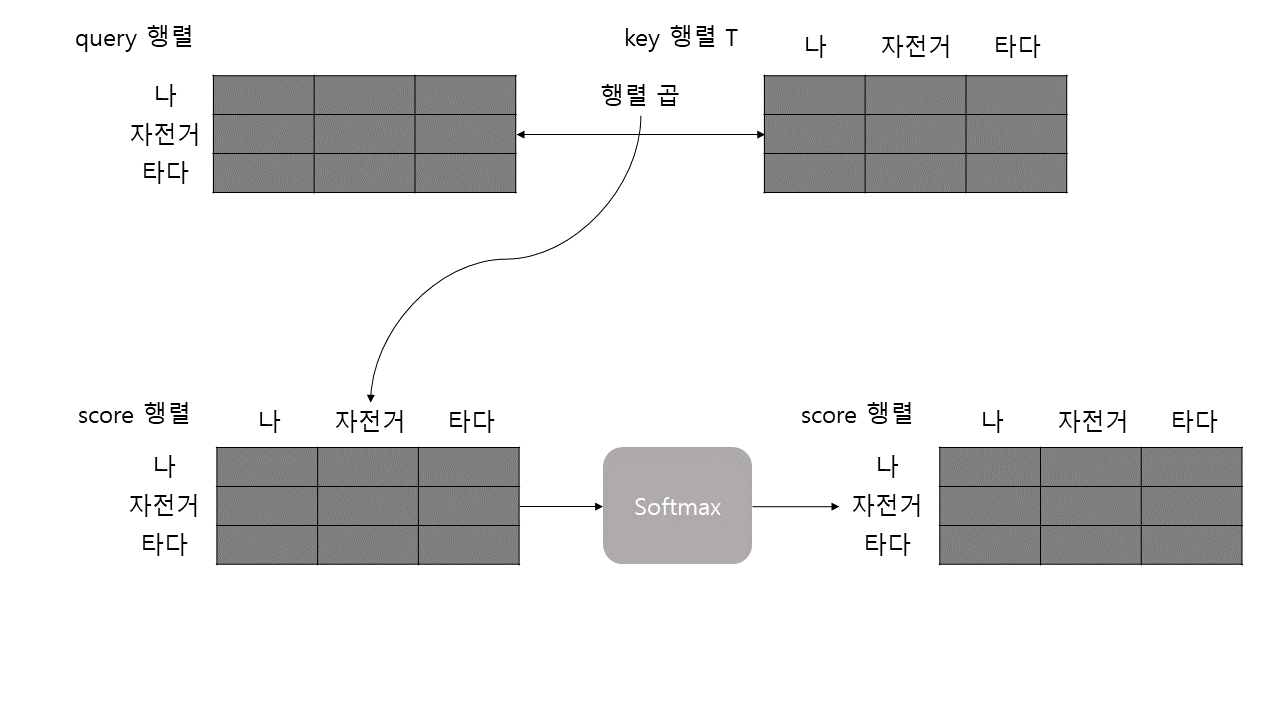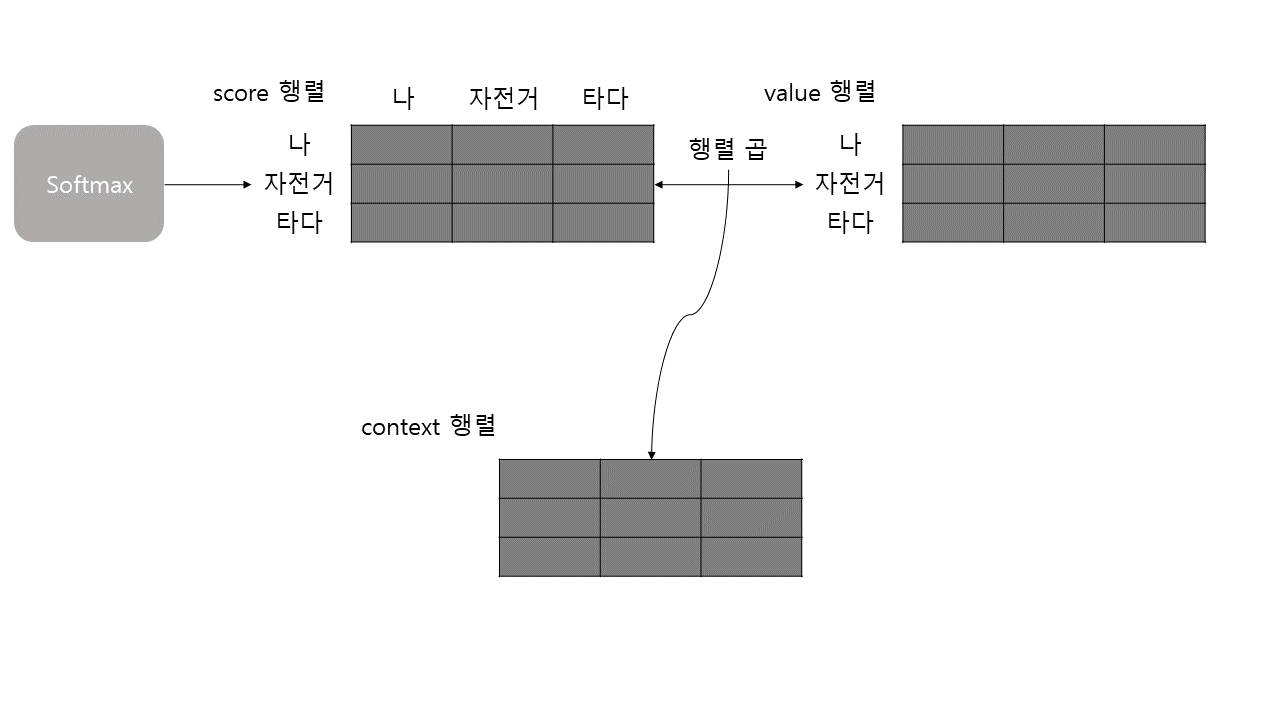
2. 순방향 마스크 어텐션
    * 순환 신경망과 다르게 스텝이 존재하지 않으며 전체 문장이 한번에 행렬 형태로 입력된다. 이러한 차이점 때문에 문장을 예측하는 과정에서 디코더 부분에 입력이 들어갈텐데 자신 보다 앞에 있는 단어만 참고해서 단어를 예측해야 한다. 하지만 트랜스포머는 전체 문장이 들어가기 때문에 위치와 상관없이 모든 단어를 참고한다. 때문에 참고하지 않게 가리는 기법을 마스크 기법이라고 한다.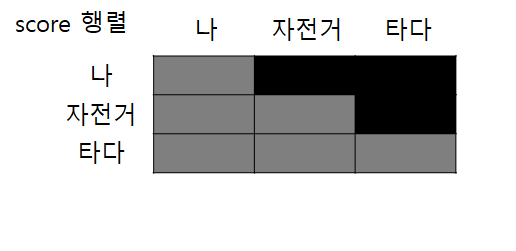